## Working with Sample Heat and Health Data pt. 2
### Regenerating Synthetic Health Data and Tuning the Lambda Parameter

Last week, I created a dataset which includes daily Tmax readings and Death counts from a single station. These death counts were manually entered by me based on intuition and knowledge that the exposure-response curve should have a J- or U-shape. We then explored fitting that data to a GAM using default settings. That data set and analysis is shown and recapped below:

Date,Station,Tmax,Deaths,Year
1/1/1989,USC00445300,42.08,21,1989
2/1/1989,USC00445300,75.02,11,1989
3/1/1989,USC00445300,53.96,25,1989
4/1/1989,USC00445300,51.98,26,1989
5/1/1989,USC00445300,75.02,14,1989
6/1/1989,USC00445300,93.92,40,1989



Family: gaussian 
Link function: identity 

Formula:
Deaths ~ s(Tmax) + s(Year)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  24.6478     0.2787   88.43   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
          edf Ref.df      F  p-value    
s(Tmax) 8.056  8.760 70.878  < 2e-16 ***
s(Year) 7.964  8.713  3.271 0.000624 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.672   Deviance explained = 68.8%
GCV = 26.101  Scale est. = 24.704    n = 318

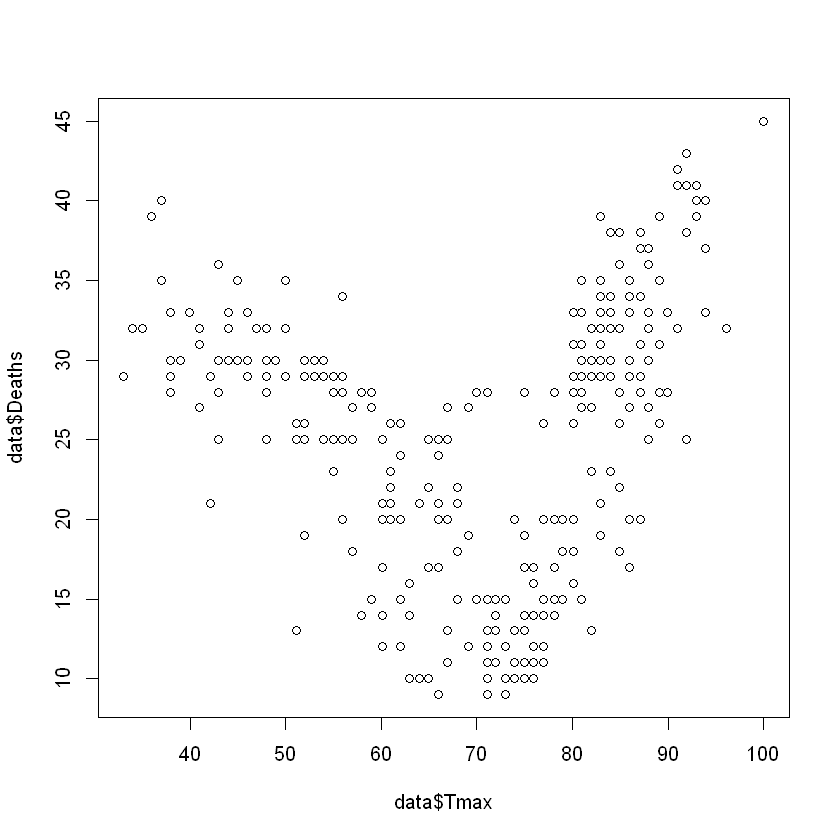

In [108]:
# this data shows the date, tmax, and my manually created "death count" for a particular station in VA
data <- read.csv(file="tmax_data.csv", header=TRUE, sep=",")
require(stringr)
data$Year <- str_sub(data$Date,-4,-1)
data$Year <- sapply(data['Year'], as.numeric)
head(data)
plot(data$Tmax, data$Deaths)
require(mgcv)
m <- gam(Deaths ~ s(Tmax) + s(Year), data=data)
summary(m)

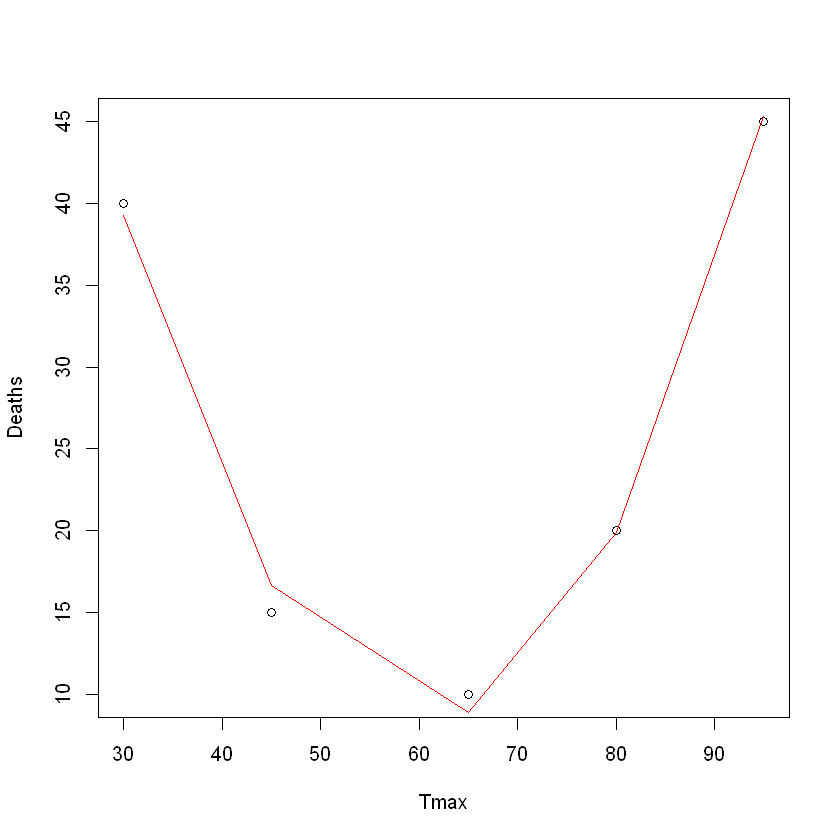

In [115]:
# I made a few date points here that represent x,y coordinates of a parabola 
# basic representative of what the exposure response curve should look like
# I modeled this and then used the model formula to generate deaths
parabola <- data.frame("Tmax" = c(30, 45, 65, 80, 95), "Deaths" = c(40, 15, 10, 20, 45))
plot(parabola)
lines(fitted(mod2) ~ Tmax, data = parabola, col = "red")


In [116]:
m2 <- lm(Deaths~Tmax + I(Tmax^2), data=parabola)
summary(m2)



Call:
lm(formula = Deaths ~ Tmax + I(Tmax^2), data = parabola)

Residuals:
      1       2       3       4       5 
 0.7347 -1.6475  1.1010  0.1061 -0.2943 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) 127.71720    5.57442   22.91  0.00190 **
Tmax         -3.90876    0.19755  -19.79  0.00254 **
I(Tmax^2)     0.03201    0.00157   20.39  0.00240 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.511 on 2 degrees of freedom
Multiple R-squared:  0.9953,	Adjusted R-squared:  0.9906 
F-statistic: 211.5 on 2 and 2 DF,  p-value: 0.004705


In [119]:
data$gen_deaths <- predict(m2, data, type="response")
head(data)

Date,Station,Tmax,Deaths,Year,gen_deaths
1/1/1989,USC00445300,42.08,21,1989,19.92128
2/1/1989,USC00445300,75.02,11,1989,14.64619
3/1/1989,USC00445300,53.96,25,1989,10.00959
4/1/1989,USC00445300,51.98,26,1989,11.03404
5/1/1989,USC00445300,75.02,14,1989,14.64619
6/1/1989,USC00445300,93.92,40,1989,42.98419


In [125]:
# Another way to generate Poisson distributed data of Tmax and Deaths
n <- 318
beta0 <- 127.71720
beta1 <- -3.90876
beta2 <- 0.03201
tmax <- runif(n=n, min=30, max=93)
# something I'm still confused about...should this be exponentiated?
mu <- beta0 + beta1 * tmax + beta2 * I(tmax^2)
deaths <- rpois(n=n, lambda=mu)
gen_data <- data.frame(tmax=tmax, deaths=deaths)
nrow(gen_data)
head(gen_data)

[1] 318

tmax,deaths
34.03002,26
43.56590,18
91.54274,27
74.53287,16
43.47107,16
71.42200,16


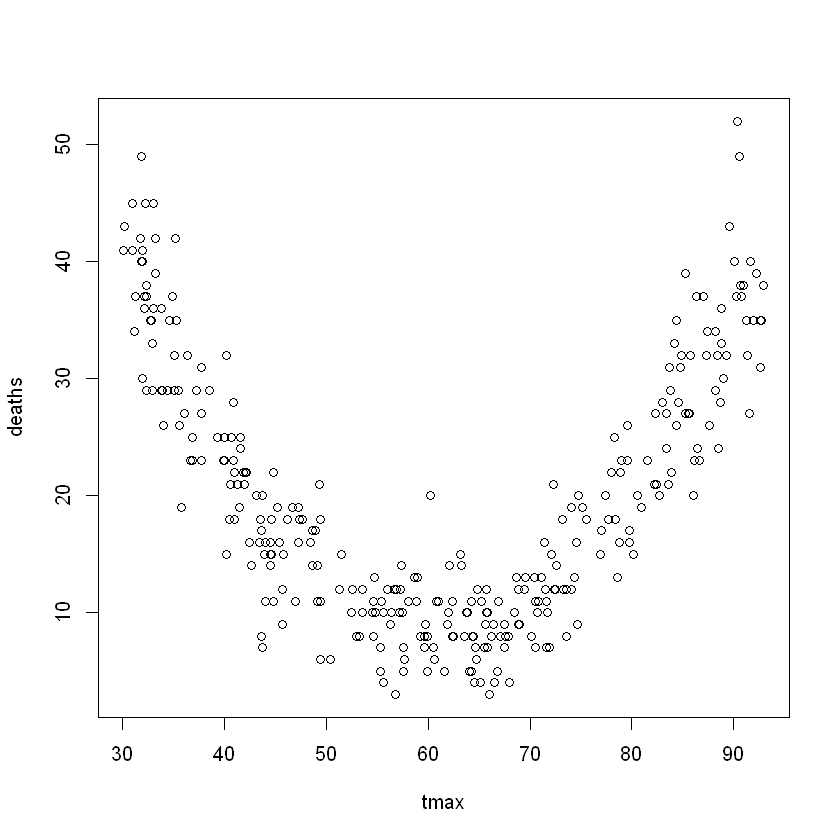

In [126]:
plot(gen_data)

In [129]:
# fit synthetic data to a GAM
m3 <- gam(deaths ~ s(tmax), data=gen_data)
summary(m3)


Family: gaussian 
Link function: identity 

Formula:
deaths ~ s(tmax)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  19.8616     0.2335   85.04   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
          edf Ref.df   F p-value    
s(tmax) 5.492  6.621 289  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.859   Deviance explained = 86.1%
GCV = 17.707  Scale est. = 17.345    n = 318

In [ ]:
# find the optimal lambda
